## Comparison of traditional statistical classification method and machine learning approach
#### Here are a flower classification problem for which the data is not images of the different species, but numerical data of different features measured from these species and is solved using regular bayesian inference. This is compared to the results of using a gradient based machine learning method of a support vector machine used for clustering and classifying data.

### Import packages

In [2]:
# Just to have som cool inline widgets
import ipywidgets as widgets
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# Load the data
The dataset consists of a table with information of each of the three different species of the iris flower such as sepal length, sepal width, petal length and petal width with 50 different subjects to each species class (total of 150 subjects). The three different flower species examined are shown below.

<img src="iris-setosa.png" width=200 height=200 style="float:left; padding-right:40px" />
<img src="Iris-versicolor.png" width=200 height=200 style="float:left; padding-right:40px" />
<img src="iris-virginica.png" width=160 height=160 style="float:left"/>
<br>


Which, from the right, is the *Iris Setosa*, *Iris Versicolor* and *Iris Virginica*
<br>
<br>
Data collected from https://archive.ics.uci.edu/ml/datasets/iris 


In [3]:
data_name = 'iris.data'
data = pd.read_csv(data_name, delimiter=',', names=['sepal length', 'sepal width', \
                                                       'petal length', "petal width",
                                                      'Species'])
print(f'Number of total subjects: {data.shape[0]}')
data.head()


Number of total subjects: 150


,sepal length,sepal width,petal length,petal width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#Plotting the relation between salary and experience
wig_col = widgets.Dropdown(
                options=[col for col in data.columns.tolist() if col.startswith(('sepal', 'petal'))],
                description='Choose a Column to Plot vs. Attributes',
                disabled=False,
                layout=widgets.Layout(width='40%', height='40px'))

# Visualizing distribution of data features
The data for each of the four different features and visualized through a distribution plot for each class.

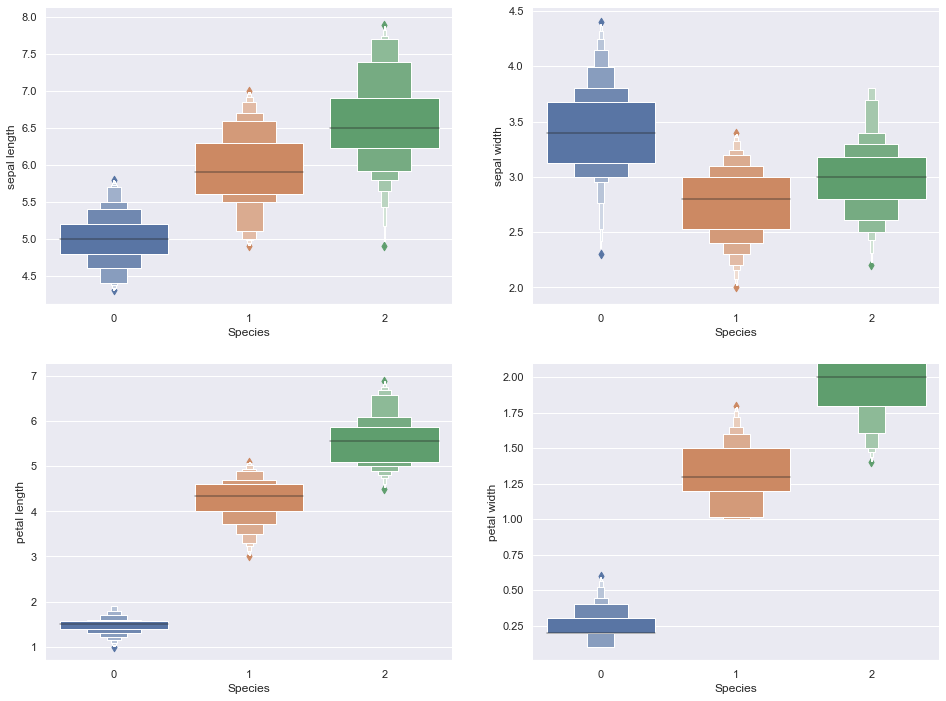

In [27]:
sns.set(style="darkgrid", color_codes=True)
features = [col for col in data.columns.tolist() if col.startswith(('sepal', 'petal'))]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.despine(left=True)
sns.catplot(x="Species", y=features[0], kind="boxen", data=data, ax = axes[0, 0])
sns.catplot(x="Species", y=features[1], kind="boxen", data=data, ax = axes[0, 1])
sns.catplot(x="Species", y=features[2], kind="boxen", data=data, ax = axes[1, 0])
sns.catplot(x="Species", y=features[3], kind="boxen", data=data, ax = axes[1, 1])
plt.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.show()

# Preprocess data
The data needs to be processed in order to make it workable. Initially, the name of the categories needs to be converted to integer values in order to index them. Thereafter the dataset needs to be divided into test and train set which is done using k-fold cross validation which uses every *k*:th value in the dataset for validation. This is a form of calibration often used when having a small dataset. Also, as part of the preprocessing, the data is normalized later on in the evaluation of the algorithm.

In [6]:

def str_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    labels = {}
    for i, value in enumerate(unique):
        labels[value] = i
    for row in dataset:
        row[column] = labels[row[column]]
    return labels

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = []
    dataset_list = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = []
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_list)) # To randomize the index to pick for test set
            fold.append(dataset_list.pop(index))
        dataset_split.append(fold)
    return dataset_split


# GAUSSIAN NAIVE BAYES
The gaussian naive bayes algorithm is based on __Bayes Theorem__ that uses the *likelihood*, *prior* and *posterior distribution* to calculate the specific class on new recieved data based on previous given data. Mathematically, it is defined as 
<br>
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)},$$ 
or as in this context,
<br>
$$P(class | data) = \frac{P(data|class)\cdot P(class)}{P(data)}.$$ 
Here, $P(class | data)$ is the posterior distribution, $P(data|class)$ is the likelihood which in this context is a gaussian distribution (also called normal distribution) and $P(class)$ is the prior defined as the probability of a recieved *data* belonging to the specific class. Furthermore is $P(data)$ the marginal distribution defined as the probability of the recieved data.
<br>
<br>
The name *naive* comes from a naive assumption that the data is conditionally independent given the class value in order to simplify the calculations as
<br>
$$ P(class_1, ..., class_n | data) = P(class_1 | data) ...  P(class_n | data) = \prod_{k=1}^n P(class_k|data),$$
for *n* classes.


## Gaussian Likelihood
The likelihood used will be the normal probability density function (also known as the gaussian pdf) defined as 
<br>
$$f(x) = \frac{1}{\sigma \sqrt{2\mu}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2},$$
where $\sigma^2$ is the variance of the input x and $\mu$ is its mean value. Other distributions such as multinomial or bernoulli can be used depending on the appereance of the actual distribution of the data. 

## Prior and probabilities
Below is the functions computing the prior and probability functions in Bayes Theorem

In [7]:
# Probability of data belonging to its class - base rate
def separate_by_class(dataset):
    separated = {}
    for i in range(len(dataset)):
        data_vec = dataset[i]
        class_value = data_vec[-1]
        if (class_value not in separated):
            separated[class_value] = []
        separated[class_value].append(data_vec)
    return separated


def mean(X):
    return sum(X)/float(len(X))

def stdev(X):
    avg = mean(X)
    variance = sum([(x-avg)**2 for x in X]) / float(len(X)-1)
    return np.sqrt(variance)

# Calculate and gather the mean, stdev and count for each feature
def summarize_dataset(dataset):
    summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
    del(summaries[-1])
    return summaries

# Split dataset by class and compute the mean, stdev and count for each sample
def summarize_by_class(dataset):
    separated = separate_by_class(dataset)
    summaries = {}
    for class_value, rows in separated.items():
        summaries[class_value] = summarize_dataset(rows)
    return summaries



## Likelihood and posterior
Below is the functions computing the likelihood and the posterior for the naive bayes algorithm

In [8]:

# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev): 
    return (1 / (np.sqrt(2 * np.pi) * stdev)) * np.exp(-((x-mean)**2 / (2 * stdev**2 )))


# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(len(class_summaries)):
            mean, stdev, _ = class_summaries[i]
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
    return probabilities




## Algorithm and Evaluation
Below is the functions for for the algorithms, predictions and evaluation of the algorithm

In [9]:
sc = StandardScaler()

# Predict the class for a given row
def predict(summaries, row):
    probabilities = calculate_class_probabilities(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label

# Naive Bayes Algorithm
def naive_bayes(train, test):
    summarize = summarize_by_class(train)
    predictions = []
    for row in test:
        output = predict(summarize, row)
        predictions.append(output)
    return predictions


# Calculate accuracy percentage
def accuracy_perc(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = []
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = []
        for row in fold:
            row_list = list(row)
            test_set.append(row_list)
            row_list[-1] = None
        train_set[:][:-1] = sc.fit_transform(train_set[:][:-1])
        test_set[:][:-1] = sc.transform(train_set[:][:-1])
        predicted = naive_bayes(train_set, test_set)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_perc(actual, predicted)
        scores.append(accuracy)
    return scores



## Running it all

In [10]:
# Converting dataframe to list for easier implementation
dataset = data.values.tolist()

# convert class column to integers
str_to_int(dataset, len(dataset[0])-1)

# evaluate algorithm with dataset split of 150/5% test ratio
n_folds = 5

# Running and evaluating algorithm
scores = evaluate_algorithm(dataset, n_folds)
print('Mean Accuracy of algorithm: %.2f%%' % (sum(scores)/float(len(scores))))

Mean Accuracy of algorithm: 95.33%


# Comparing to ML-solution
Comparing the naive bayes algorithm to a machine learning approach using a support vector classifier that uses a gradient based regression learning to predict the iris species 

# Preprocess data
Dividing the dataset into labels and input data (y and x), encoding it and then splitting it up into a train and test set. Lastly, normalizing the input data

In [11]:
# Seperating into x and y
X = data.iloc[:,:-1].values  
y = data.iloc[:,-1].values

In [12]:
# Encode the labels
labelencoder = LabelEncoder()
data['Species'] = labelencoder.fit_transform(data['Species'])
labels = data['Species']
print(f'Number of unique labels: {len(np.unique(labels))}')

Number of unique labels: 3


In [13]:
# Choose ratio size of test set
test_size = widgets.FloatSlider(min=0.01, max=0.6, value=0.2, description="Test Size :", tooltips=['Usually 20-30%'])
display(test_size)

FloatSlider(value=0.2, description='Test Size :', max=0.6, min=0.01)

In [14]:
# Dividing into test/train with test ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=test_size.value, random_state = 0) 
print(f"Size of input vector of training set: {X_train.shape}")
print(f"Size of input vector of test set: {X_test.shape}")

Size of input vector of training set: (120, 4)
Size of input vector of test set: (30, 4)


In [15]:
# Normalizing the input data
print('Input before normalizing: \n', X_test[:1])
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 
print('\n Input after normalizing: \n', X_test[:1])


Input before normalizing: 
 [[5.8 2.8 5.1 2.4]]

 Input after normalizing: 
 [[-0.09544771 -0.58900572  0.72247648  1.51195265]]


# Import the Support Vector Machine Classifier
Using the already built SVC from sklearn and trains it on the training data

In [18]:
from sklearn.svm import SVC
import time


model = SVC()
init_time = time.time()
model = model.fit(X_train,y_train)
print('Time of training process: {:.4f} seconds'.format(time.time() - init_time))

Time of training process: 0.0020 seconds


### Predicting on the test data and calculate accuracy

In [19]:
y_pred=model.predict(X_test)

In [20]:
acc_list = (y_pred==y_test).astype(int)
acc = (sum(acc_list) / len(acc_list))*100
print('Accuracy on test set: %.2f%%' % acc)

Accuracy on test set: 100.00%


### As seen above, the SVC reached 100% accuracy on the test set containing 30 samples after training on 120 samples which took 2 ms. This is alot better than the naive bayes algorithm which still had a decent performance